In [1]:
import numpy as np
from scipy.stats import binom, beta, norm, uniform, bernoulli, multivariate_normal, truncnorm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.cm as cm
from python_code import beta_binomial_model as bb
import imageio

## Inferring the probability of heads "p" using binomial likelihood and beta prior

In [2]:
beta_binom_model = bb.BetaBinomial(beta_a_param=2, beta_b_param=2, n_heads=8, n_total=30, initial_probability_heads=.5)
beta_binom_model.fit()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:00<00:00, 5019.79it/s]


In [3]:
def make_analytical_posterior(a_param=2, b_param=2, n_heads=8, n_total=30):
    return beta(a=n_heads+b_param, b=b_param+n_total-n_heads)

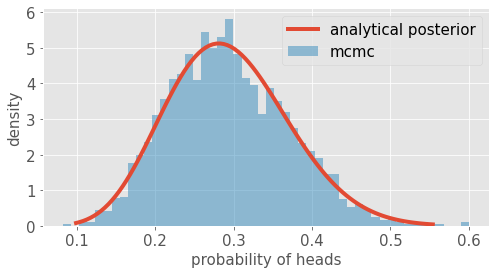

In [4]:
plt.figure(figsize=(8,4))
true_posterior_dist = make_analytical_posterior()
probability_range = np.linspace(true_posterior_dist.ppf(.001), true_posterior_dist.ppf(.999),100)
plt.plot(probability_range, true_posterior_dist.pdf(probability_range), lw=4, label='analytical posterior')
plt.hist(beta_binom_model.probability_heads_traces, bins=50,density=True, alpha=.5, label='mcmc');
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.ylabel('density', fontsize=15)
plt.xlabel('probability of heads', fontsize=15);

/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_10423/2656367194.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,4))


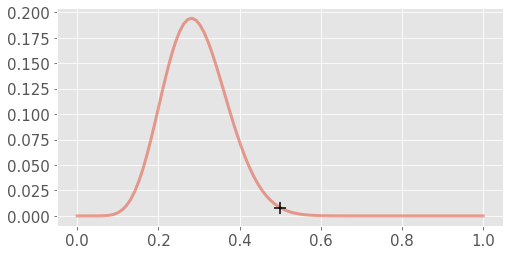

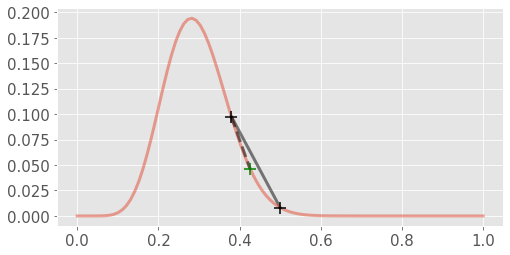

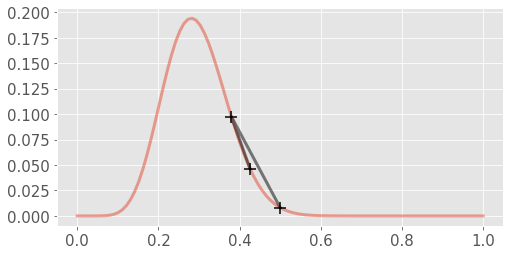

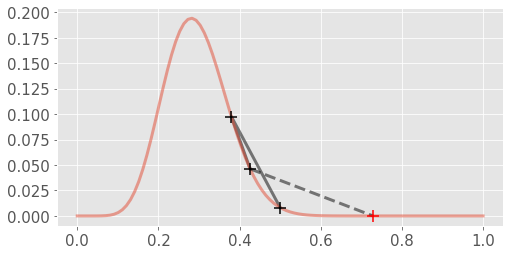

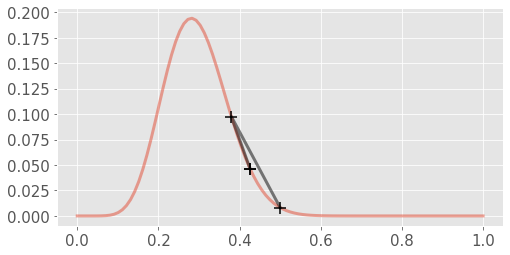

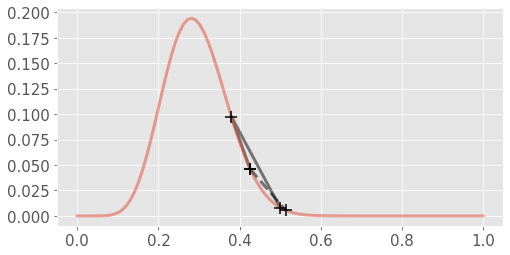

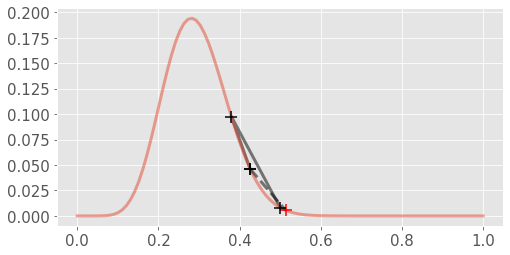

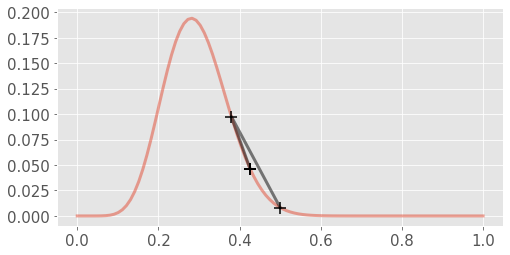

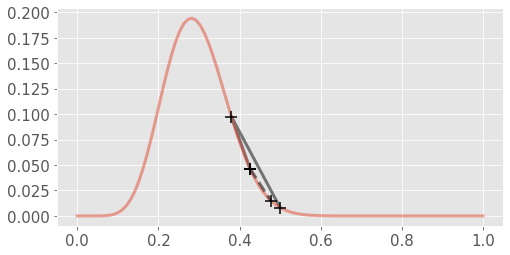

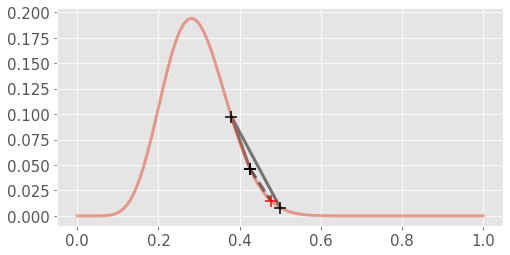

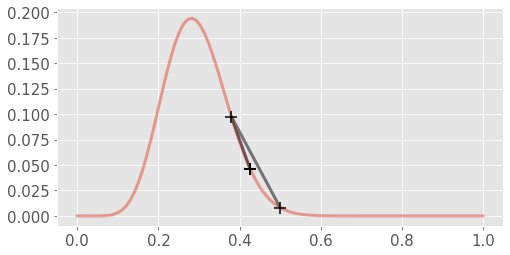

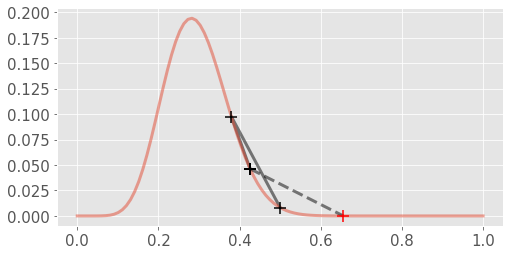

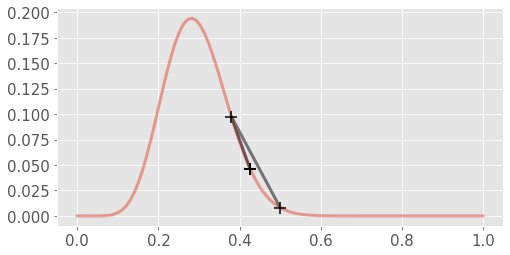

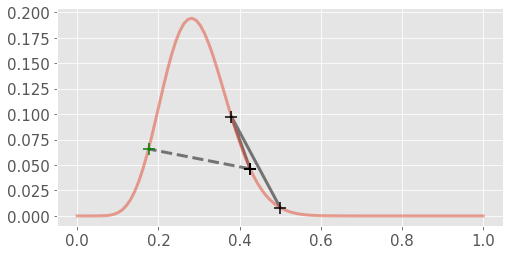

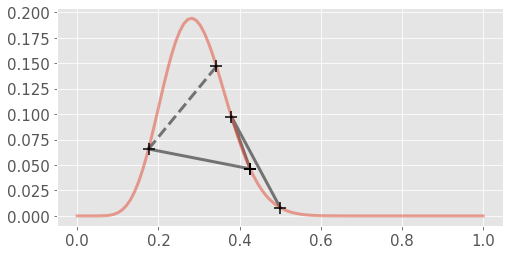

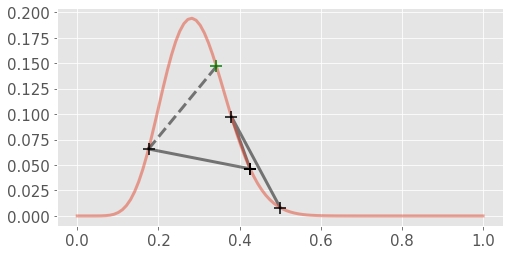

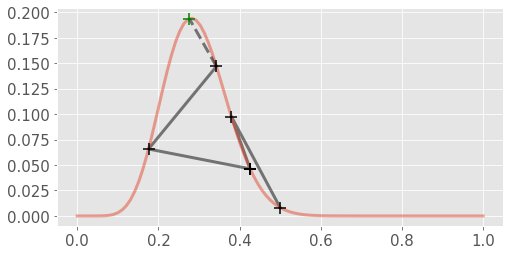

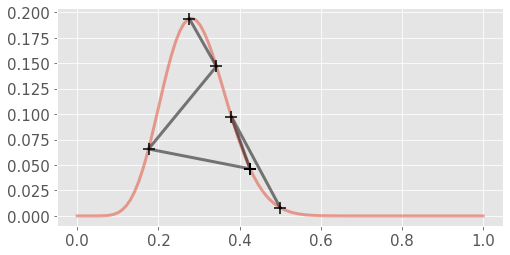

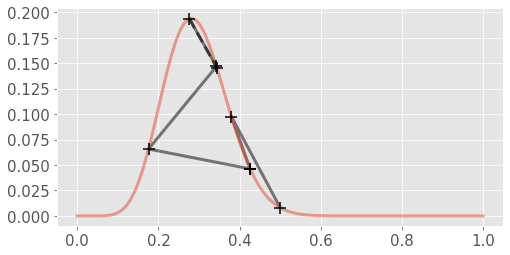

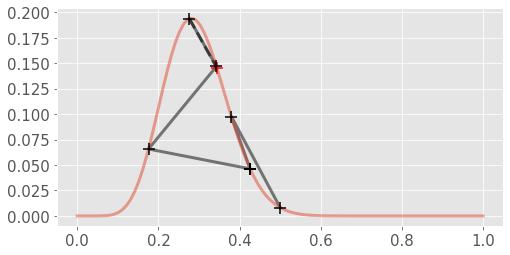

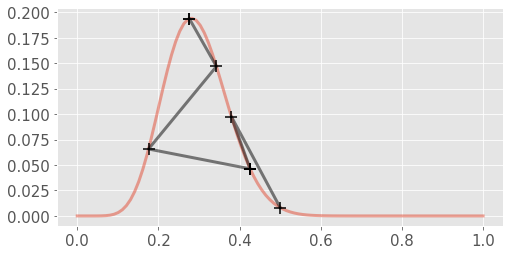

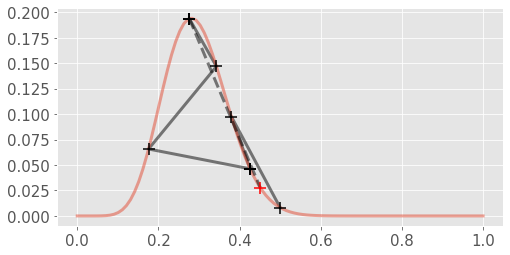

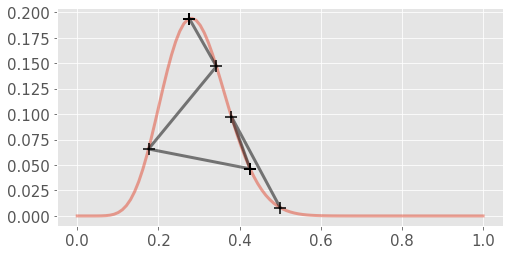

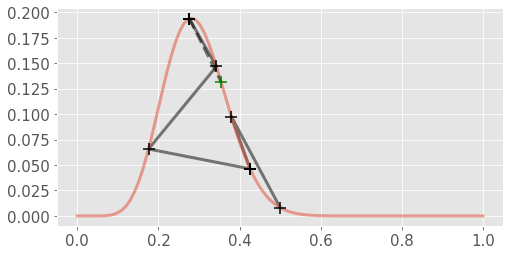

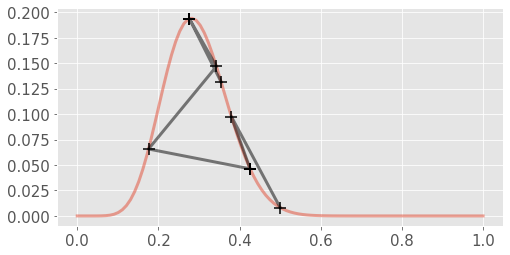

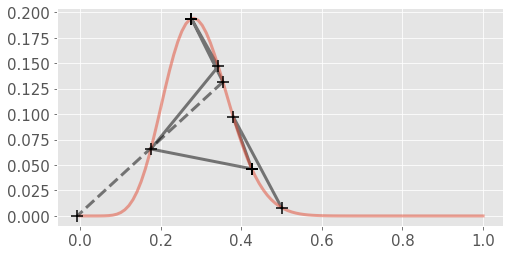

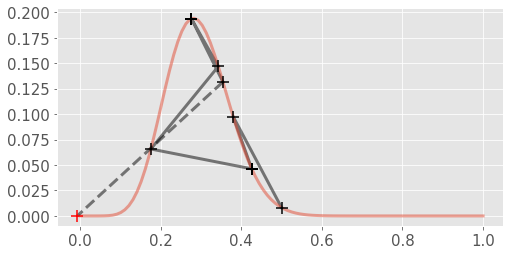

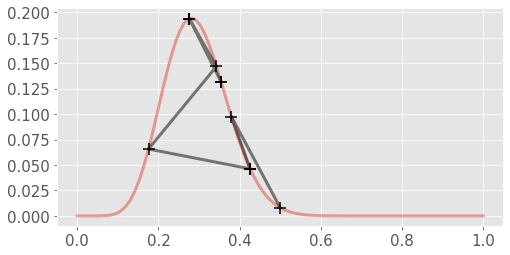

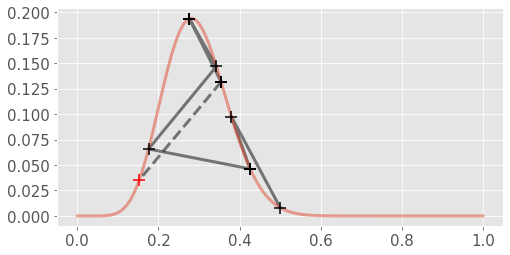

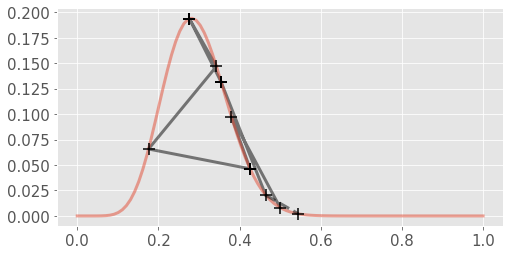

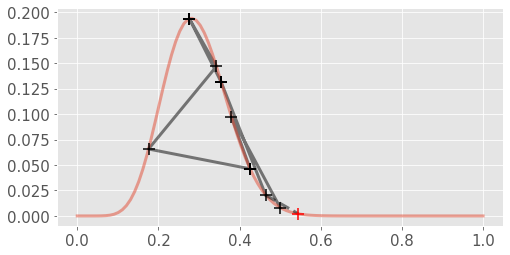

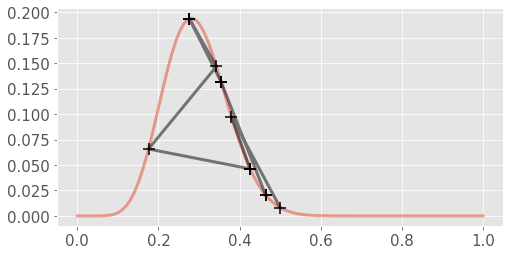

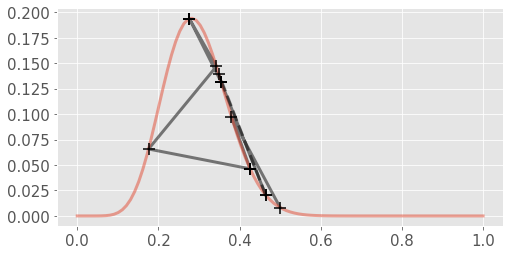

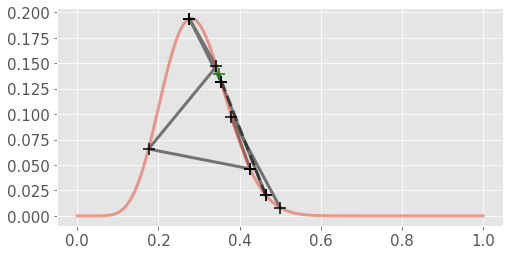

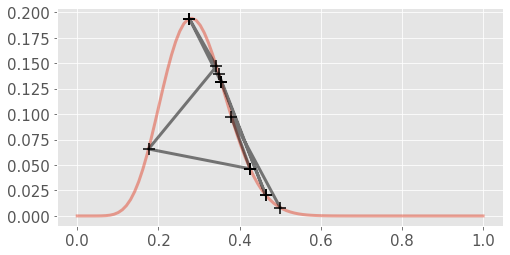

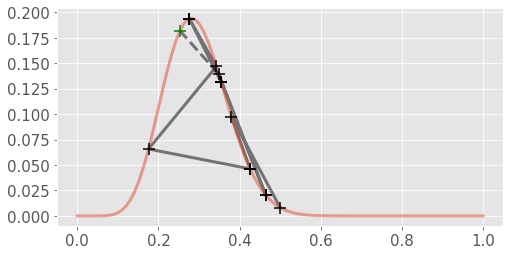

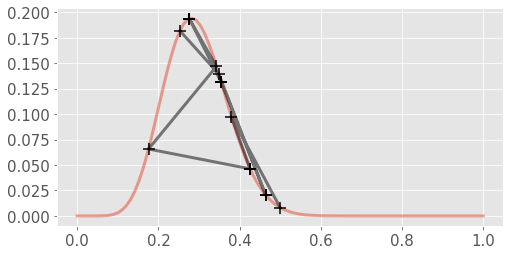

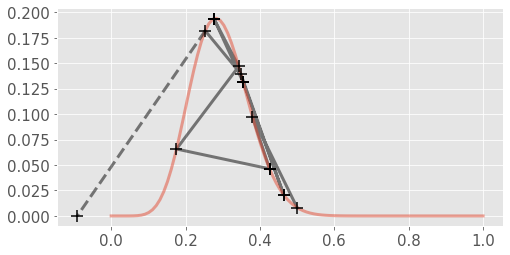

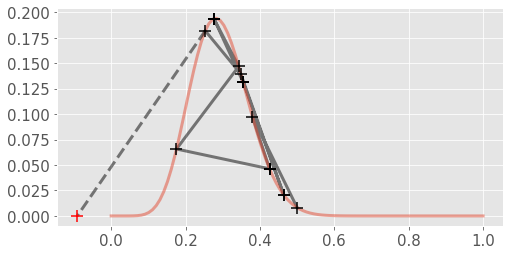

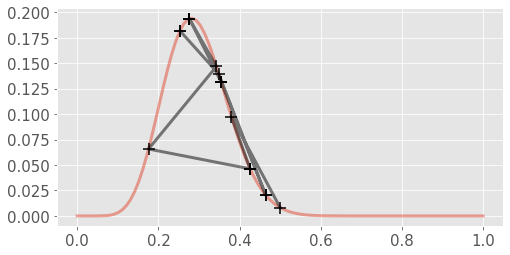

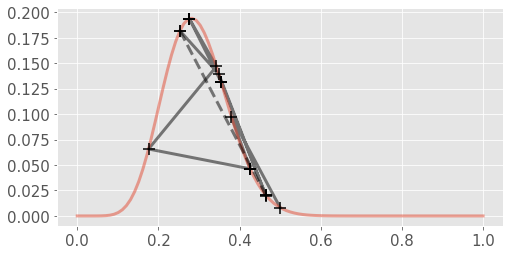

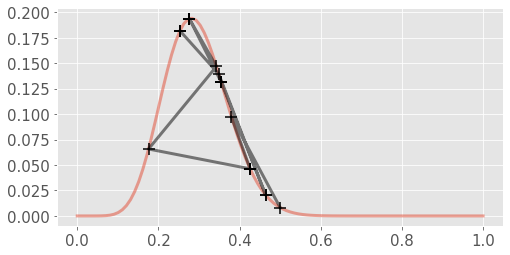

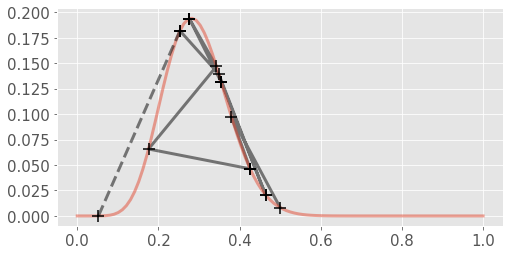

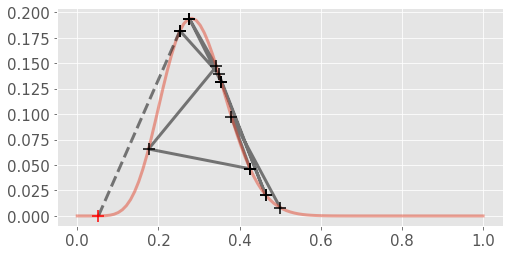

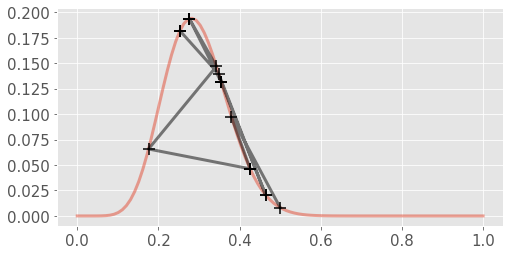

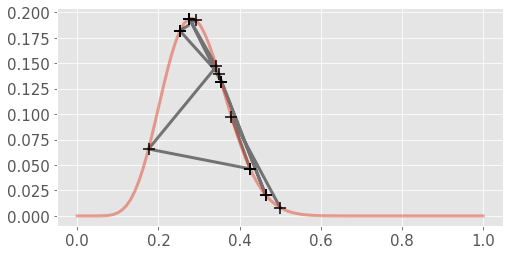

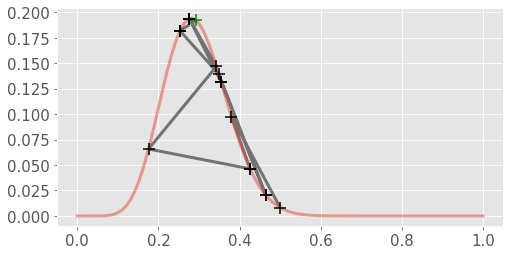

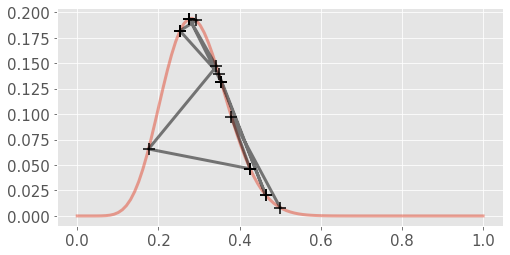

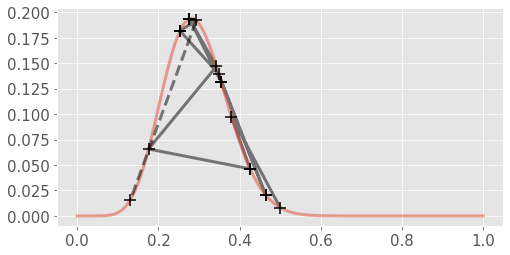

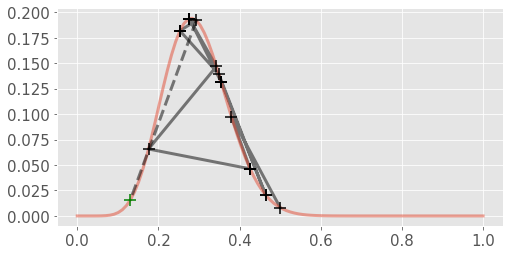

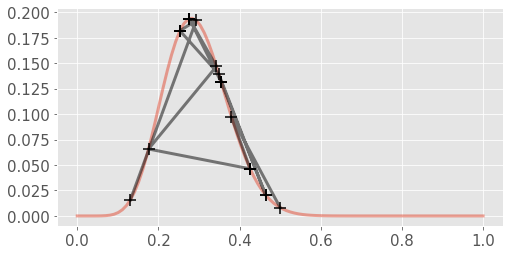

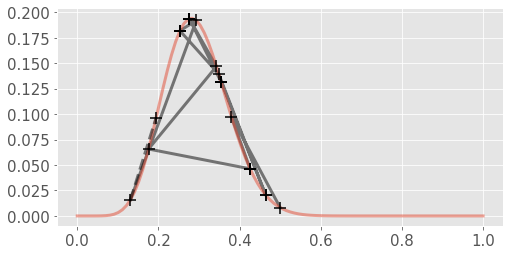

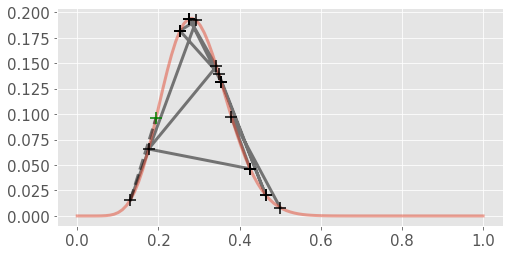

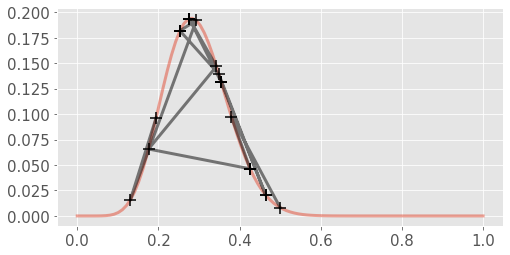

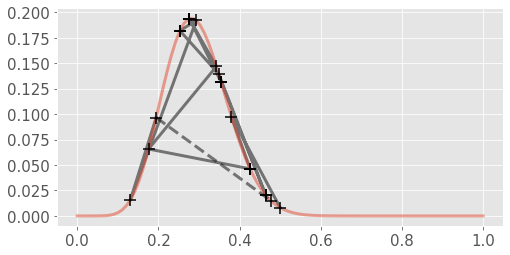

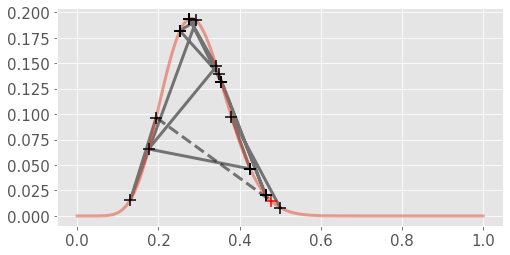

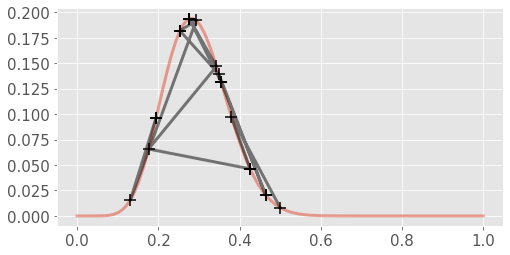

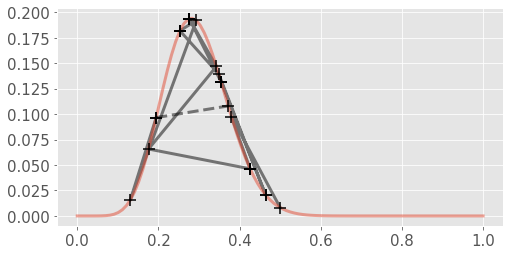

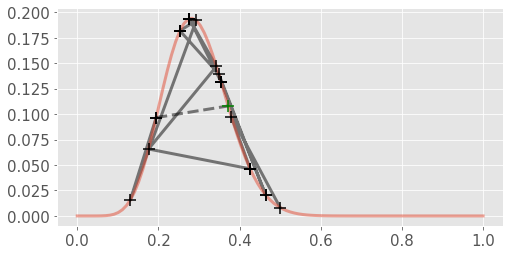

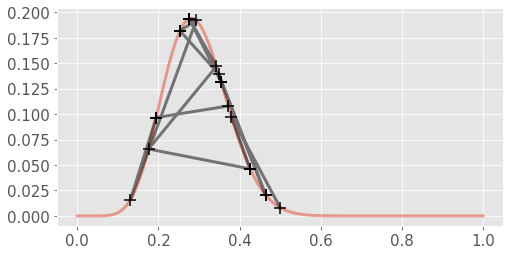

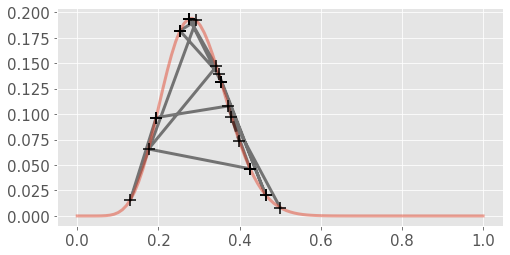

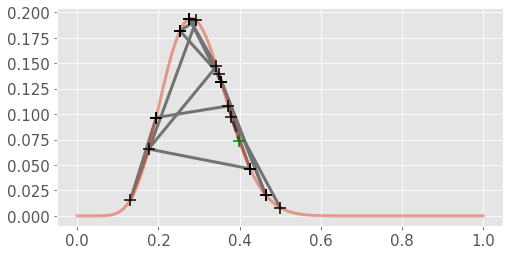

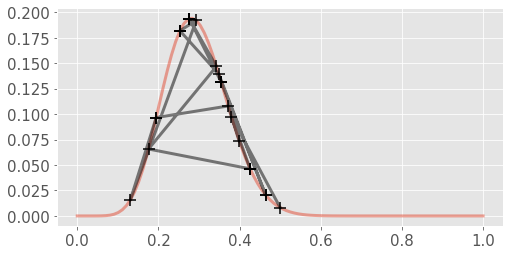

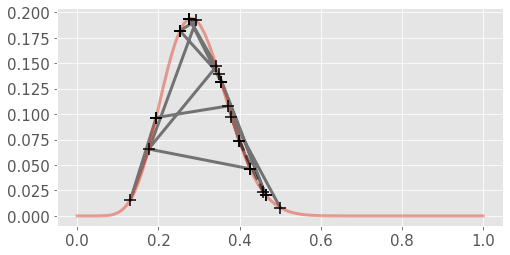

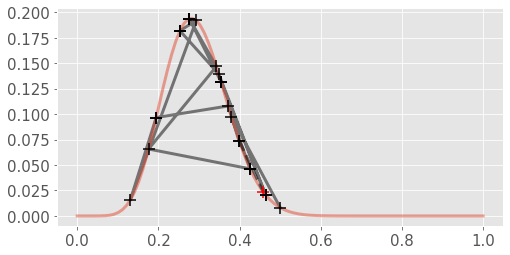

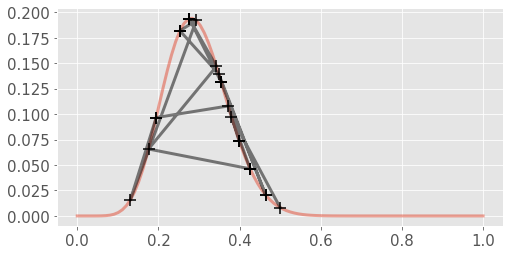

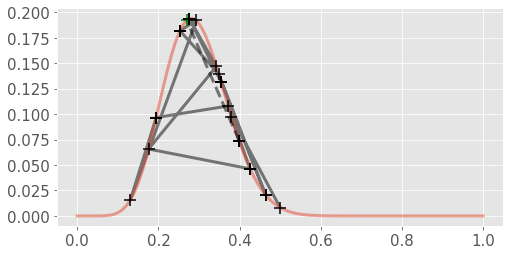

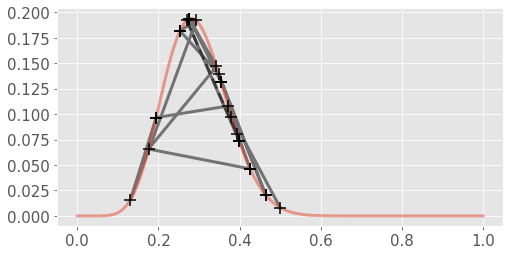

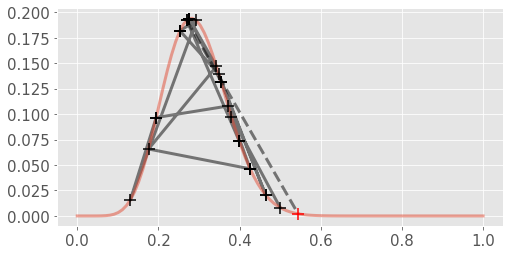

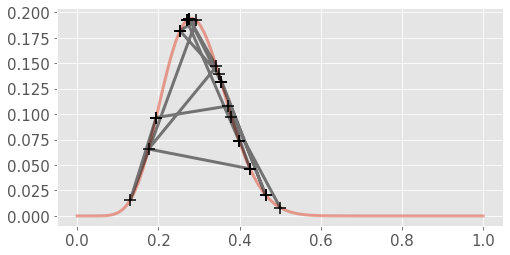

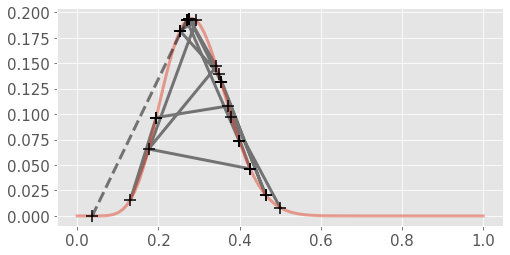

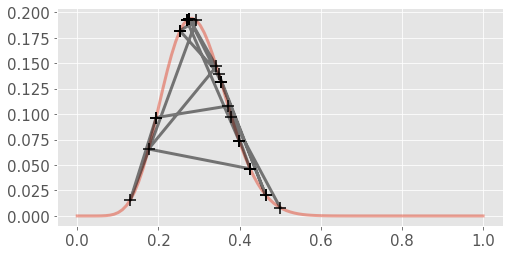

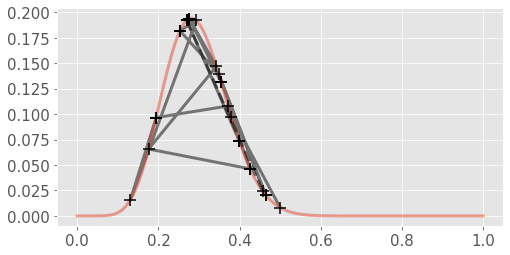

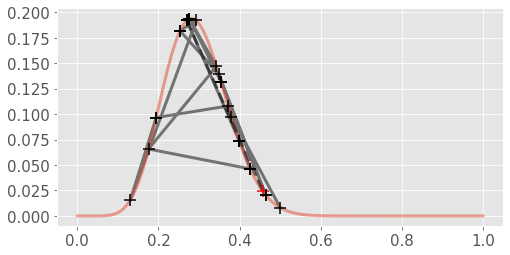

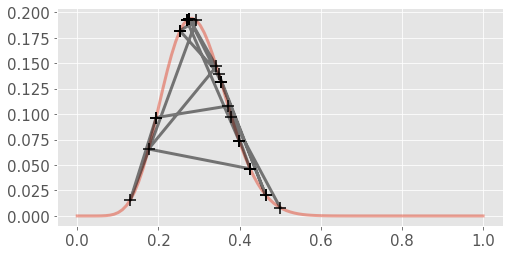

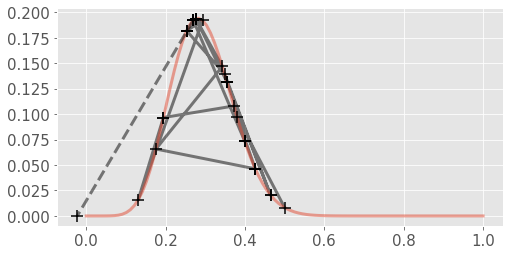

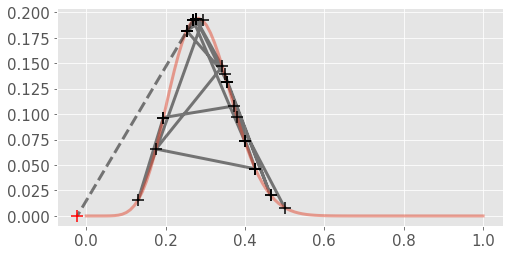

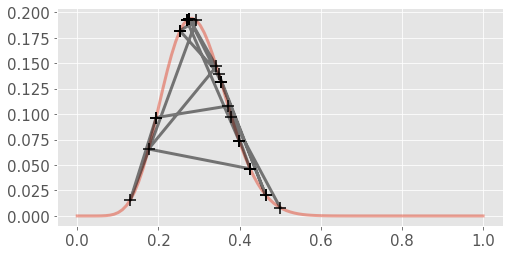

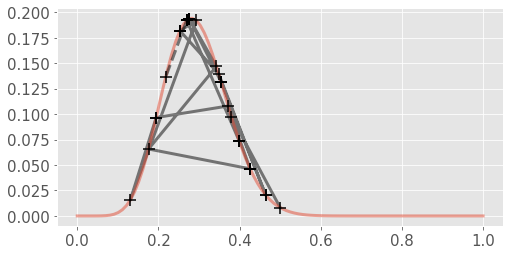

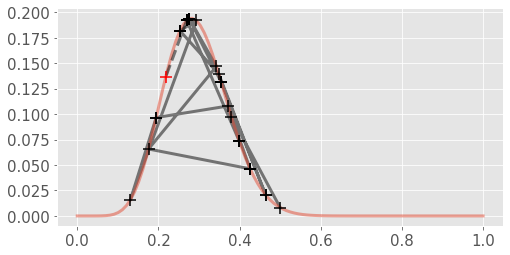

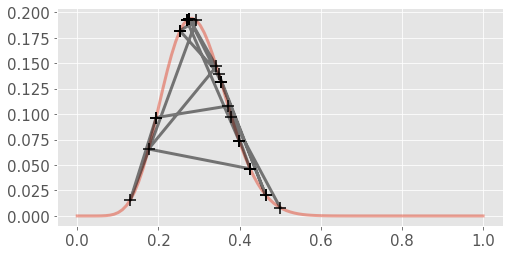

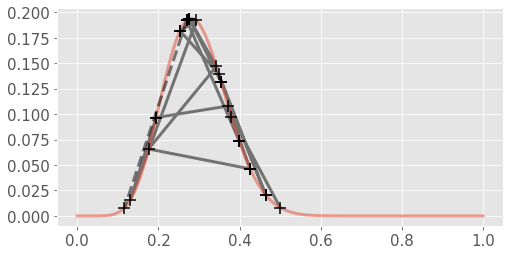

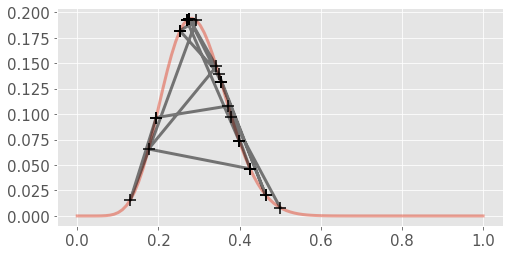

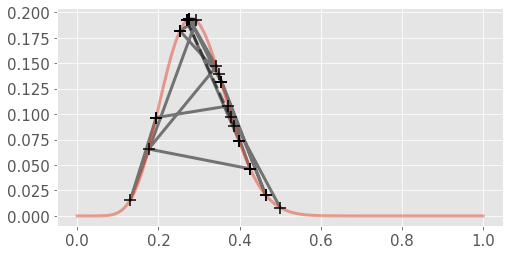

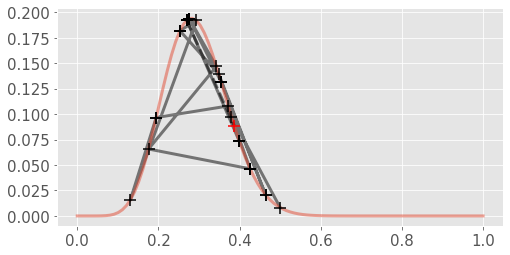

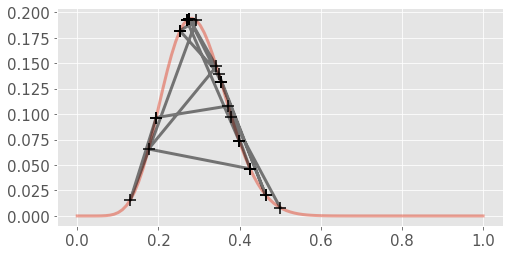

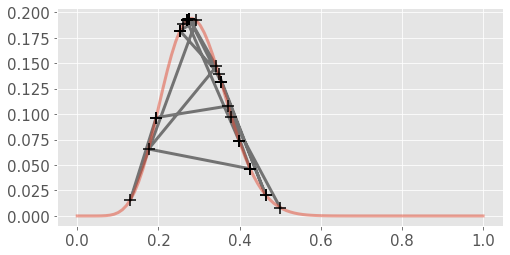

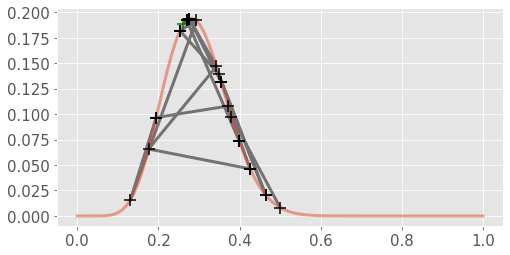

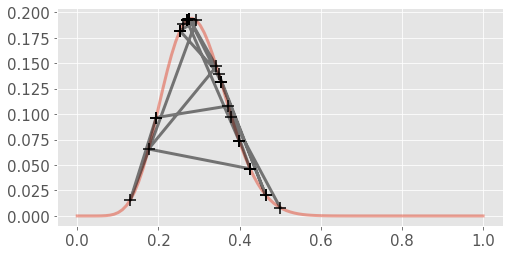

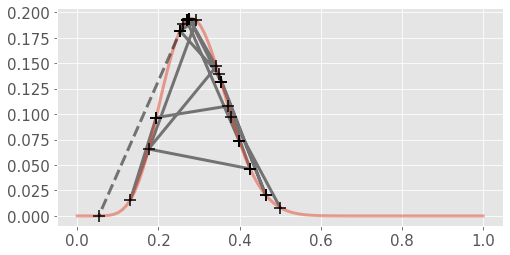

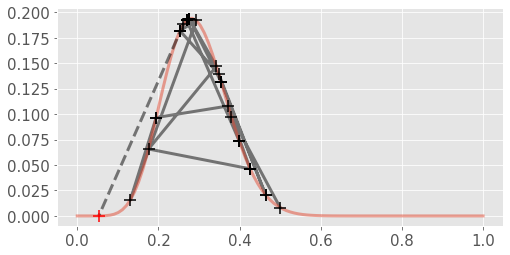

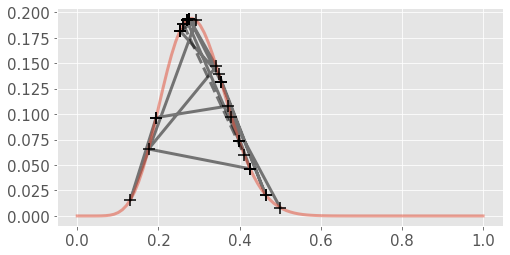

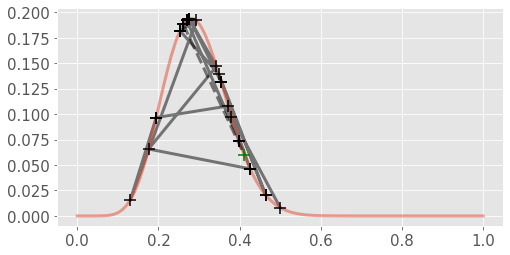

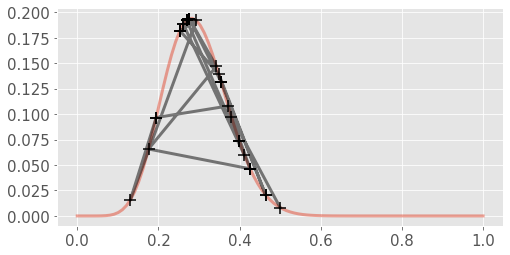

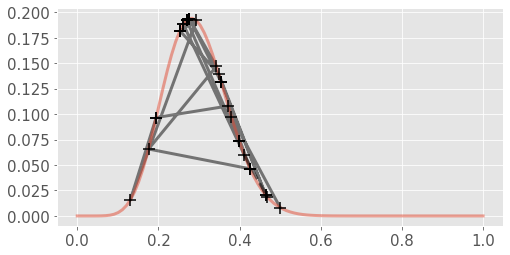

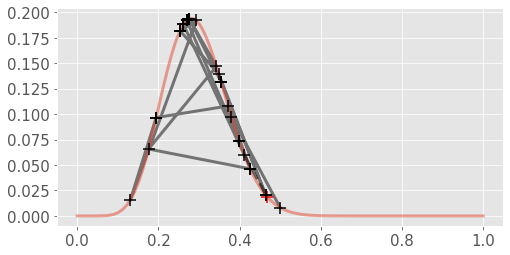

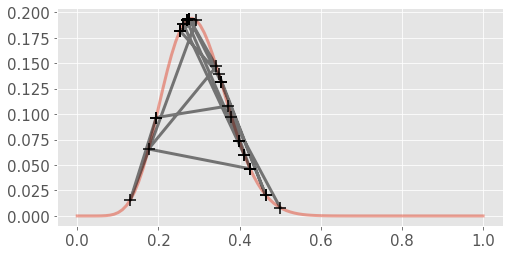

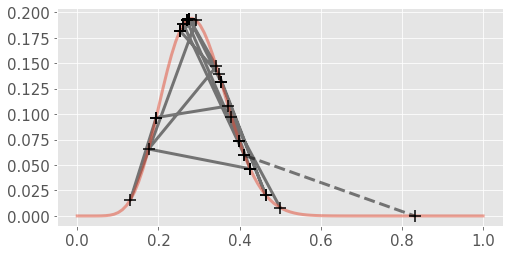

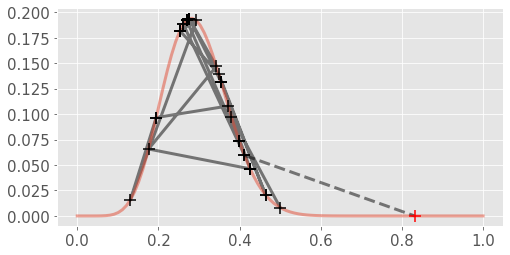

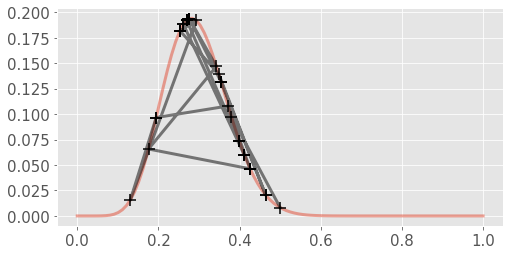

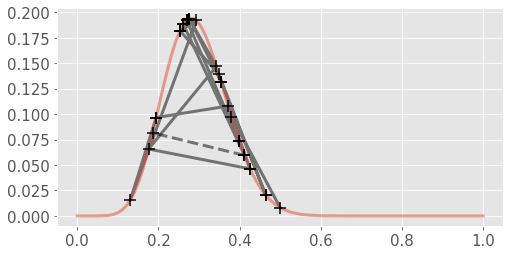

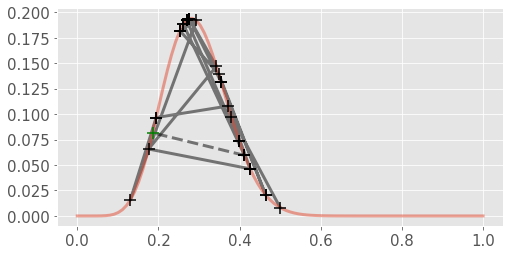

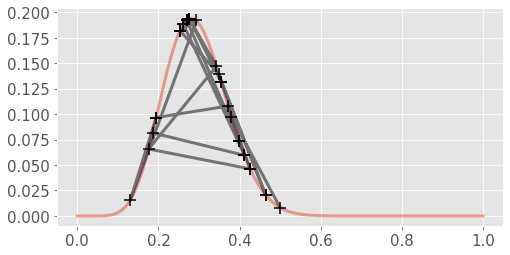

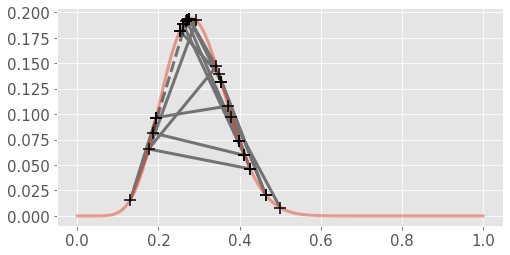

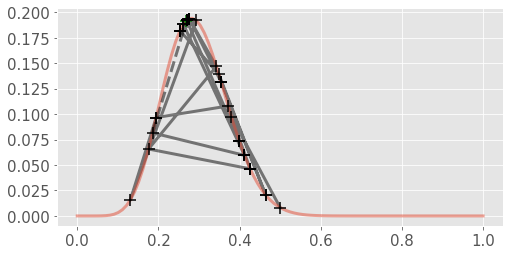

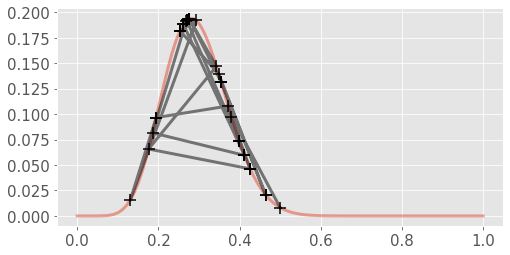

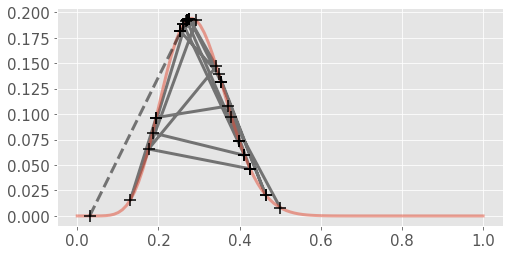

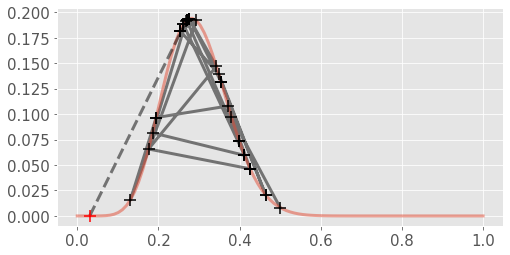

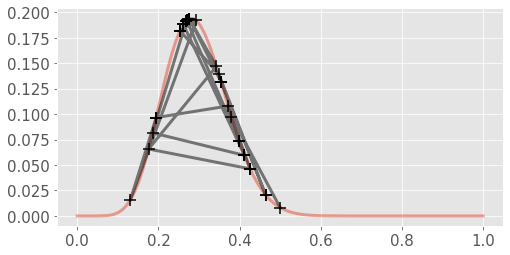

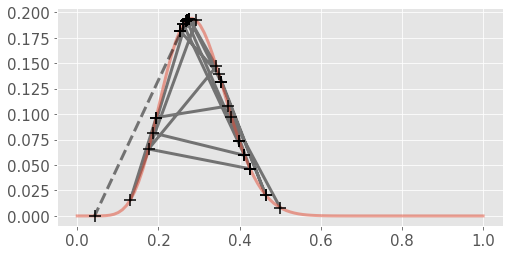

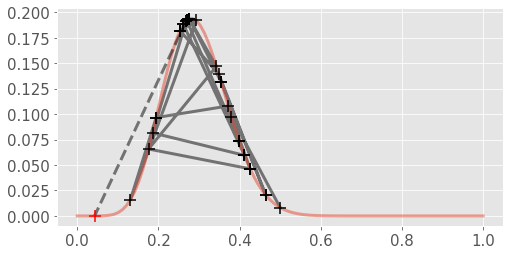

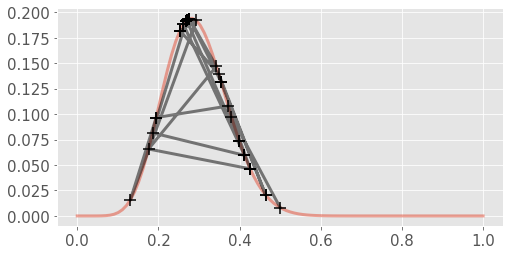

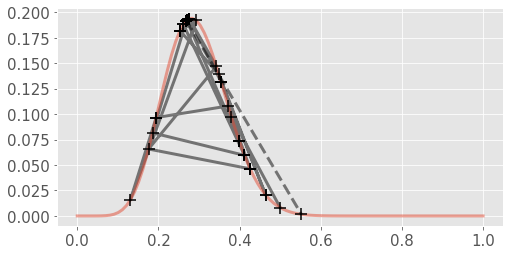

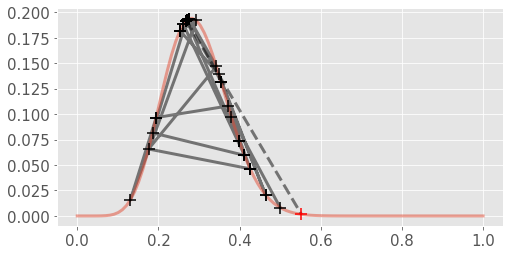

In [14]:
n_iter_plot = 50
filenames = []
probability_range = np.linspace(0, 1, 100)
posteriors = [beta_binom_model._calculate_posterior(probability) for probability in probability_range]
for it in range(n_iter_plot):
    plt.figure(figsize=(8,4))
    plt.plot(probability_range, posteriors, lw=3, alpha=.5)
    probabilities_heads = beta_binom_model.probability_heads_traces[:it+1]
    posteriors_probabilities_heads = beta_binom_model.posteriors[:it+1]
    plt.scatter(probabilities_heads, posteriors_probabilities_heads, color='black', marker='+', s=150, zorder=3)
    plt.plot(probabilities_heads, posteriors_probabilities_heads, color='black', alpha=.5, lw=3)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('p', fontsize-)
    plt.figure(figsize=(8,4))
    plt.plot(probabilities_heads, posteriors_probabilities_heads, color='black', alpha=.5, lw=3)
    plt.plot(probability_range, posteriors, lw=3, alpha=.5)
    proposal = beta_binom_model.proposals[it]
    posterior_proposal = beta_binom_model._calculate_posterior(proposal)
    plt.plot([beta_binom_model.probability_heads_traces[it], proposal],[beta_binom_model.posteriors[it], posterior_proposal], lw=3, alpha=.5, linestyle='--', color='black')
    plt.scatter(probabilities_heads, posteriors_probabilities_heads, color='black', marker='+', s=150, zorder=3)
    plt.scatter(proposal, posterior_proposal, color='black', marker='+', s=150, zorder=3)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.figure(figsize=(8,4))
    plt.plot(probabilities_heads, posteriors_probabilities_heads, color='black', alpha=.5, lw=3)
    plt.plot(probability_range, posteriors, lw=3, alpha=.5)
    if beta_binom_model.accept_array[it] == True:
        plt.scatter(proposal, posterior_proposal, color='green', marker='+', s=150, zorder=3)
    else:
        plt.scatter(proposal, posterior_proposal, color='red', marker='+', s=150, zorder=3)
    plt.plot([beta_binom_model.probability_heads_traces[it], proposal],[beta_binom_model.posteriors[it], posterior_proposal], lw=3, alpha=.5, linestyle='--', color='black')
    plt.scatter(probabilities_heads, posteriors_probabilities_heads, color='black', marker='+', s=150, zorder=3)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)  
     
    

    
    
    
#writer = []
#for filename in filenames:
#    image = imageio.imread(filename)
 #   writer.append(image)
#imageio.mimsave('new_gif.gif', writer, fps=1.7)

In [ ]:
plt.figure(figsize=(8,4))
probability_range = np.linspace(0, 1, 100)
posterior_range = [beta_binom_model._calculate_posterior(probability) for probability in probability_range] 
plt.plot(probability_range, posterior_range, lw=3);
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('posterior probability', fontsize=15)
plt.xlabel('probability of heads', fontsize=15);


## Inferring $\beta$ in logistic regression

In [ ]:
def calculate_logit(x_with_intercept, betas):
    return 1/(1+np.exp(-x_with_intercept@betas))

def calculate_prior_density_betas(betas, prior_mean_betas, prior_std_betas):
    betas_priors = norm.pdf(loc=prior_mean_betas, scale=prior_std_betas, x=betas)
    return np.prod(betas_priors)

def calculate_likelihood_density_y(probabilities, y):
    return np.prod([bernoulli.pmf(p=probabilities[n], k=y[n]) for n in range(y.shape[0])])

def initialize_betas(n_iter, n_betas, betas_initial):
    betas_traces = np.zeros((n_iter, n_betas))
    betas_traces[0, :] = betas_initial
    return betas_traces
    
def initialize_betas_posteriors(n_iter, x_with_intercept, y, initial_betas, prior_mean_betas, prior_std_betas):
    posteriors = np.zeros(n_iter)
    initial_posterior = calculate_posterior(x_with_intercept, initial_betas, prior_mean_betas, prior_std_betas, y)
    posteriors[0] = initial_posterior
    return posteriors

def calculate_posterior(x_with_intercept, betas, prior_mean_betas, prior_std_betas, y):
    prior_density = calculate_prior_density_betas(betas, prior_mean_betas, prior_std_betas)
    logits = calculate_logit(x_with_intercept, betas)
    likelihood_density = calculate_likelihood_density_y(logits, y)
    return likelihood_density * prior_density
    
def do_random_walk(x, y, initial_betas, prior_mean_betas, prior_std_betas, proposal_std, n_iter): 
    x_with_intercept =  np.vstack([np.ones(x.shape[0]), x]).T
    n_betas = x_with_intercept.shape[1]
    proposals = np.zeros((n_iter-1, n_betas))
    posteriors = initialize_betas_posteriors(n_iter, x_with_intercept, y, initial_betas, prior_mean_betas, prior_std_betas)
    betas_traces = initialize_betas(n_iter, n_betas, initial_betas)
    accept_array = np.zeros(n_iter-1, dtype=bool)
    for i in tqdm(range(n_iter-1)):
        betas_proposal = norm.rvs(loc=betas_traces[i, :], scale=np.ones(n_betas) * proposal_std)
        proposals[i] = betas_proposal
        betas_proposal_posterior = calculate_posterior(x_with_intercept, betas_proposal, prior_mean_betas, prior_std_betas, y)
        ratio = betas_proposal_posterior/posteriors[i]
        if ratio > uniform.rvs():
            posteriors[i+1] = betas_proposal_posterior
            betas_traces[i+1, :] = betas_proposal
            accept_array[i] = True
        else:
            posteriors[i+1] = posteriors[i]
            betas_traces[i+1, :] = betas_traces[i, :]
    return accept_array, proposals, betas_traces   

In [ ]:
n_points = 100
minimum_study_hours = 0
maximum_study_hours = 10
x = np.random.uniform(minimum_study_hours, maximum_study_hours, n_points)
x_with_intercept =  np.vstack([np.ones(x.shape[0]), x]).T
beta = np.array([-3, 1])
probabilities = calculate_logit(x_with_intercept, beta)
y = bernoulli.rvs(p=probabilities)
initial_betas = np.zeros(x_with_intercept.shape[1])
prior_mean_betas = 0
prior_std_betas = 1e3
proposal_std = .5
n_iter = 5000

In [ ]:
n_chains = 4
n_iter = 5000
betas_chains = np.zeros((n_chains, n_iter, n_betas))
proposals_chains = np.zeros((n_chains, n_iter-1, n_betas))
accept_array_chains = np.zeros((n_chains, n_iter-1))
for n in range(n_chains): 
    accept_array_chains[n], proposals_chains[n], betas_chains[n] = do_random_walk(x, y, initial_betas, prior_mean_betas, prior_std_betas, proposal_std, n_iter)
    

In [ ]:
plt.figure(figsize=(13, 6))
n_burn = 1000
posterior_means = np.concatenate(betas_chains[:,n_burn:]).mean(axis=0)

def plot_traces(betas_chain, n_burn, posterior_means):
    for coef in range(n_betas):
        plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20c.colors[coef*4:])
        plt.subplot(2, 2, 2*coef+1)
        plt.plot(betas_chains[:,:,coef].T, alpha=.8)
        plt.ylabel(fr'$\beta_{coef}$', fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        max_val, min_val = np.max(betas_chains[:,:,coef]), np.min(betas_chains[:,:,coef])
        plt.fill_between([0, n_burn],[min_val, min_val], [max_val, max_val], color='black',
                     alpha=0.2, label='burn in')
        plt.xlabel('iteration number', fontsize=15)
        plt.legend(fontsize=12)
        plt.subplot(2, 2, 2*coef+2)
        for chain in range(n_chains):
            plt.hist(betas_chains[chain,n_burn:,coef].T, alpha=.4, bins=50)
        plt.axvline(x=posterior_means[coef], color='black', alpha=.8, lw=3, linestyle=':', label='posterior mean')
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.xlabel(fr'$\beta_{coef}$', fontsize=15)
        plt.ylabel('density',fontsize=15)
        plt.legend(fontsize=12)
    plt.tight_layout()
plot_traces(betas_chains, n_burn, posterior_means)

In [ ]:
chain_no = 2
beta_0_range = np.linspace(np.min(proposals_chains[chain_no][:,0]-0.2), np.max(proposals_chains[chain_no][:,0]+0.2), n_points)
beta_1_range = np.linspace(np.min(proposals_chains[chain_no][:,1]-0.2), np.max(proposals_chains[chain_no][:,1]+0.2), n_points)
beta_0, beta_1 = np.meshgrid(beta_0_range, beta_1_range)
all_traces =  np.concatenate(betas_chains[:,n_burn:])
iterations = np.linspace(0, n_iter, n_iter)

In [ ]:
betas_grid = np.array([beta_0.flatten(), beta_1.flatten()])

In [ ]:
posteriors_betas = [calculate_posterior(x_with_intercept, betas_grid[:, n], prior_mean_betas, prior_std_betas, y) for n in range(betas_grid.shape[1])]                                                                                                  

In [ ]:
n_max = 50
filenames = []
for it in range(proposals_chains[chain_no][0:n_max].shape[0]):
    plt.figure(facecolor='white')
    plt.grid(False)
    contour=plt.contourf(beta_0_range, beta_1_range, np.array(np.log(posteriors_betas)).reshape(n_points,n_points), cmap='coolwarm', levels=150, alpha=.2)
    plt.scatter(betas_chains[chain_no, :it+1, 0], betas_chains[chain_no, :it+1, 1], color='black', marker='+', s=150)
    plt.plot(betas_chains[chain_no, :it+1, 0], betas_chains[chain_no, :it+1, 1], color='black', alpha=.5)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel(fr'$\beta_0$', fontsize=15)
    plt.ylabel(fr'$\beta_1$', fontsize=15)
    filename = f'video_figs/{3*it+1}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    filenames.append(filename)
    plt.figure(facecolor='white')
    contour = plt.contourf(beta_0_range, beta_1_range, np.array(np.log(posteriors_betas)).reshape(n_points,n_points), levels=150, cmap='coolwarm',alpha=.2)
    plt.plot(betas_chains[chain_no, :it+1, 0], betas_chains[chain_no, :it+1, 1], color='black', alpha=.5)
    plt.grid(False)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel(fr'$\beta_0$', fontsize=15)
    plt.ylabel(fr'$\beta_1$', fontsize=15)
    plt.scatter(proposals_chains[chain_no, it, 0], proposals_chains[chain_no, it, 1], color='black', marker='+', s=150)
    plt.plot([betas_chains[chain_no, it, 0], proposals_chains[chain_no, it, 0]], [betas_chains[chain_no, it, 1], proposals_chains[chain_no, it, 1]], linestyle='--', color='black', alpha=.5)
    plt.scatter(betas_chains[chain_no, :it+1, 0], betas_chains[chain_no, :it+1, 1], color='black', marker='+', s=150)
    filename = f'video_figs/{3*it+2}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    filenames.append(filename)
    plt.figure(facecolor='white')
    contour = plt.contourf(beta_0_range, beta_1_range, np.array(np.log(posteriors_betas)).reshape(n_points,n_points), levels=150, cmap='coolwarm',alpha=.2)
    plt.plot(betas_chains[chain_no, :it+1, 0], betas_chains[chain_no, :it+1, 1], color='black', alpha=.5)
    plt.grid(False)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel(fr'$\beta_0$', fontsize=15)
    plt.ylabel(fr'$\beta_1$', fontsize=15)
    plt.plot([betas_chains[chain_no, it, 0], proposals_chains[chain_no, it, 0]], [betas_chains[chain_no, it, 1], proposals_chains[chain_no, it, 1]], linestyle='--', color='black', alpha=.5)
    if accept_array_chains[chain_no, it] == True:
            plt.scatter(proposals_chains[chain_no, it, 0], proposals_chains[chain_no, it, 1], color='green', marker='+', s=150)
    else:
        plt.scatter(proposals_chains[chain_no, it, 0], proposals_chains[chain_no, it, 1], color='red', marker='+', s=150)
    plt.scatter(betas_chains[chain_no, :it+1, 0], betas_chains[chain_no, :it+1, 1], color='black', marker='+', s=150)
    filename = f'video_figs/{3*it+3}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    filenames.append(filename)
    
writer = []
for filename in filenames:
    image = imageio.imread(filename)
    writer.append(image)
imageio.mimsave('new_gif.gif', writer, fps=1.7)


In [ ]:
plt.plot(proposals_chains[chain_no][:,0])
plt.plot(betas_chains[chain_no][:,0])